In [1]:
import requests
import datetime
import re

from bs4 import BeautifulSoup
from bs4 import NavigableString

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
%matplotlib inline

from plot_util import *
from clear_data_util import *

In [8]:
flats = pd.read_csv('dags/avito_data_processing/avito/flats_2020-07-17.csv')
old_flats = pd.read_csv('dags/avito_data_processing/avito/2019/finish_flats_2019.csv')

# Clear and enrich

In [9]:
old_flats.rename(columns={'metroDistance':'metro_distance', 
                          'metroStation':'metro_station',
                          'adress': 'address',
                          'apartmentType': 'apartment_type',
                          'apartmentSquare': 'square',
                          'apartmentFloor': 'apartment_floor',
                          'buildingFloor': 'building_floor'}, inplace=True)

In [ ]:
def rename_floor_columns(flats):
    flats.rename(columns={'building_floor':'apartment_floor', 'floor':'building_floor'}, inplace=True)
rename_floor_columns(flats)

In [177]:
old_flats['year'] = 2019
flats['year'] = 2020

for _flats in [flats, old_flats]:
    remove_duplicates(_flats)
    clear_apartment_type(_flats)
    clear_countryside_area(_flats)
    cast_postal_code(_flats)
    add_apartment_type_order_column(_flats)
    sort_by_apartment_type(_flats)
    compute_converted_distance(_flats)
    compute_apartment_floor_group(_flats)
    compute_city_side(_flats)
    compute_floor_group(_flats)

In [12]:
flats.head()

,href,apartment_type,price,address,square,apartment_floor,building_floor,commission_percent,time_of_creation,agency,...,metro_station,latitude,longitude,postal_code,area,year,apartment_type_order,converted_distance,apartment_floor_group,floor_group
0,/nizhniy_novgorod/kvartiry/1-k_kvartira_32_m_1...,1-к квартира,11000,"Южное ш., 30А",32.0,1,5,60,2020-07-06 10:27:00,Агентство,...,Парк Культуры,56.226779,43.866810,603147,Автозаводский район,2020,1,1700.0,Заречная часть,1
1,/nizhniy_novgorod/kvartiry/1-k_kvartira_42_m_6...,1-к квартира,13000,"Заречный б-р, 5",42.0,6,16,60,2020-07-06 10:08:00,Агентство,...,Заречная,56.283665,43.941353,603076,Ленинский район,2020,1,800.0,Заречная часть,3
2,/nizhniy_novgorod/kvartiry/2-k_kvartira_45_m_4...,2-к квартира,12000,"Южное ш., 32",45.0,4,5,0,2020-07-06 09:27:00,NaN,...,Парк Культуры,56.227285,43.867942,603147,Автозаводский район,2020,2,1700.0,Заречная часть,1
3,/nizhniy_novgorod/kvartiry/studiya_40_m_1015_e...,Студия,20000,"Малая Ямская ул., 63",40.0,10,15,70,2020-07-06 13:14:00,Агентство,...,Горьковская,56.309853,43.979989,603000,Советский район,2020,0,1000.0,Нагорная часть,3
4,/nizhniy_novgorod/kvartiry/studiya_19_m_1117_e...,Студия,11000,"Южный б-р, 15",19.0,11,17,60,2020-07-06 08:41:00,Агентство,...,Парк Культуры,56.217200,43.865059,603142,Автозаводский район,2020,0,2700.0,Заречная часть,3


# Remove apartments with 5 rooms 
#### We have only one row with this type of apartment so we will remove this type from our dataset.

In [13]:
flats[flats.apartment_type == '5-к квартира']

,href,apartment_type,price,address,square,apartment_floor,building_floor,commission_percent,time_of_creation,agency,...,metro_station,latitude,longitude,postal_code,area,year,apartment_type_order,converted_distance,apartment_floor_group,floor_group
1283,/nizhniy_novgorod/kvartiry/5-k_kvartira_104_m_...,5-к квартира,25000,"Волжская наб., 9",104.0,6,16,40,2020-07-15 13:09:00,Агентство,...,Стрелка,56.345294,43.940894,603159,Канавинский район,2020,5,1200.0,Заречная часть,3


In [14]:
old_flats[old_flats.apartment_type == '5-к квартира']

,href,price,agency,commissionPercent,metro_distance,metro_station,address,metroLine,apartment_type,square,...,relativeTime,latitude,longitude,postalCode,area,year,apartment_type_order,converted_distance,apartment_floor_group,floor_group
1009,/nizhniy_novgorod/kvartiry/5-k_kvartira_200_m_...,100000,Агентство,0 %,600 м,Горьковская,"Нижний Новгород, Холодный пер, 7",Автозаводская линия,5-к квартира,200.0,...,4 дня назад,56.318990,43.999357,603000.0,Нижегородский район,2019,5,600,Нагорная часть,1
1038,/nizhniy_novgorod/kvartiry/5-k_kvartira_101_m_...,45000,NaN,0 %,1.3 км,Заречная,"Нижний Новгород, Гончарова, д. 1",Автозаводская линия,5-к квартира,101.0,...,5 дней назад,56.278073,43.944730,603032.0,Ленинский район,2019,5,1000,Заречная часть,2
1087,/nizhniy_novgorod/kvartiry/5-k_kvartira_197_m_...,75000,Агентство,0 %,300 м,Горьковская,"Нижний Новгород, ул Новая, 15",Автозаводская линия,5-к квартира,197.0,...,4 дня назад,56.311596,43.996985,603000.0,Советский район,2019,5,300,Нагорная часть,1
1777,/nizhniy_novgorod/kvartiry/5-k_kvartira_220_m_...,200000,Агентство,60 %,1.3 км,Горьковская,"Нижний Новгород, Варварская улица, 27/8",Автозаводская линия,5-к квартира,220.0,...,3 недели назад,56.320413,44.012248,603006.0,Нижегородский район,2019,5,1000,Нагорная часть,2


In [15]:
flats = flats[flats.apartment_type != '5-к квартира']
old_flats = old_flats[old_flats.apartment_type != '5-к квартира']

# Data utils

In [17]:
def bound_flats_py_price(flats, low=5_000, high=45_000):
    return flats[(flats['price']>low) & (flats['price']<high)]

---
---
---
# Our statisitcs will have 3 point:
1) Basic statisitcs for flats dates by Jule 2020

2) We will give assumptions to price dependence feature

3) We will to compare 2019 flats with 2020 flats prices 

---
---
---
# Basic statistics on Jule 2020


###  by `apartment type`

## Most low cost apartments by type 

In [18]:
most_low_cost_apartments_by_type = flats.sort_values('price',ascending = True) \
     .groupby('apartment_type') \
     .head(1) \
     .sort_values('apartment_type_order',ascending = True)
most_low_cost_apartments_by_type

,href,apartment_type,price,address,square,apartment_floor,building_floor,commission_percent,time_of_creation,agency,...,metro_station,latitude,longitude,postal_code,area,year,apartment_type_order,converted_distance,apartment_floor_group,floor_group
1721,/nizhniy_novgorod/kvartiry/studiya_22_m_33_et....,Студия,4500,"Поселок Новинки, жк Окский берег",22.0,3,3,0,2020-06-29 16:57:00,NaN,...,Горьковская,56.183599,43.875991,<NA>,область,2020,0,1500.0,область,1
1149,/nizhniy_novgorod/kvartiry/1-k_kvartira_40_m_3...,1-к квартира,4000,"сельский пос. Новинки, жилой комплекс Окский Б...",40.0,3,3,0,2020-07-07 11:48:00,NaN,...,без метро,56.183599,43.875991,<NA>,область,2020,1,NaN,область,1
910,/nizhniy_novgorod/kvartiry/2-k_kvartira_47_m_2...,2-к квартира,8000,"ул. Лескова, 7",47.0,2,5,70,2020-07-07 10:27:00,NaN,...,Парк Культуры,56.235641,43.864807,603016,Автозаводский район,2020,2,700.0,Заречная часть,1
1243,/nizhniy_novgorod/kvartiry/3-k_kvartira_45_m_2...,3-к квартира,10000,"ул. Литвинова, 22",45.0,2,2,0,2020-07-04 14:36:00,NaN,...,Московская,56.319759,43.948279,603002,Канавинский район,2020,3,200.0,Заречная часть,1
440,/nizhniy_novgorod/kvartiry/4-k_kvartira_100_m_...,4-к квартира,25000,"ул. Василия Иванова, 46",100.0,3,5,25,2020-07-14 11:00:00,Агентство,...,без метро,56.364860,43.825713,603050,Сормовский район,2020,4,NaN,Заречная часть,1


## Most high cost apartments by type

In [20]:
most_high_cost_apartments_by_type = flats.sort_values('price',ascending = False) \
     .groupby('apartment_type') \
     .head(1) \
     .sort_values('apartment_type_order',ascending = True)
most_high_cost_apartments_by_type

,href,apartment_type,price,address,square,apartment_floor,building_floor,commission_percent,time_of_creation,agency,...,metro_station,latitude,longitude,postal_code,area,year,apartment_type_order,converted_distance,apartment_floor_group,floor_group
38,/nizhniy_novgorod/kvartiry/studiya_50_m_810_et...,Студия,30000,"ул. Белинского, 36",50.0,8,10,70,2020-07-06 08:37:00,Агентство,...,Горьковская,56.310113,43.996374,603000,Нижегородский район,2020,0,400.0,Нагорная часть,2
1825,/nizhniy_novgorod/kvartiry/1-k_kvartira_67_m_4...,1-к квартира,35000,"ул. Володарского, 40",67.0,4,8,70,2020-06-22 12:31:00,Агентство,...,Горьковская,56.319519,44.013020,603006,Нижегородский район,2020,1,1300.0,Нагорная часть,2
1594,/nizhniy_novgorod/kvartiry/2-k_kvartira_100_m_...,2-к квартира,80000,"ул. Максима Горького, 43",100.0,12,18,70,2020-07-03 15:05:00,Агентство,...,Горьковская,56.312125,43.982298,603000,Нижегородский район,2020,2,800.0,Нагорная часть,3
913,/nizhniy_novgorod/kvartiry/3-k_kvartira_122_m_...,3-к квартира,100000,"Холодный пер., 10",122.0,4,8,70,2020-07-07 16:01:00,Агентство,...,Горьковская,56.319479,44.001666,603000,Нижегородский район,2020,3,800.0,Нагорная часть,2
1872,/nizhniy_novgorod/kvartiry/4-k_kvartira_138_m_...,4-к квартира,125000,"ул. Пискунова, 26",138.0,2,4,0,2020-07-08 13:10:00,Агентство,...,Горьковская,56.325085,44.009553,<NA>,Нижегородский район,2020,4,1500.0,Нагорная часть,1


# Avarage values by apartment type

In [22]:
avarage_by_type = flats.groupby(['apartment_type']).mean().sort_values('apartment_type_order').price
avarage_by_type

apartment_type
Студия          11897.470588
1-к квартира    14114.045455
2-к квартира    19883.372881
3-к квартира    27108.333333
4-к квартира    65181.818182
Name: price, dtype: float64

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


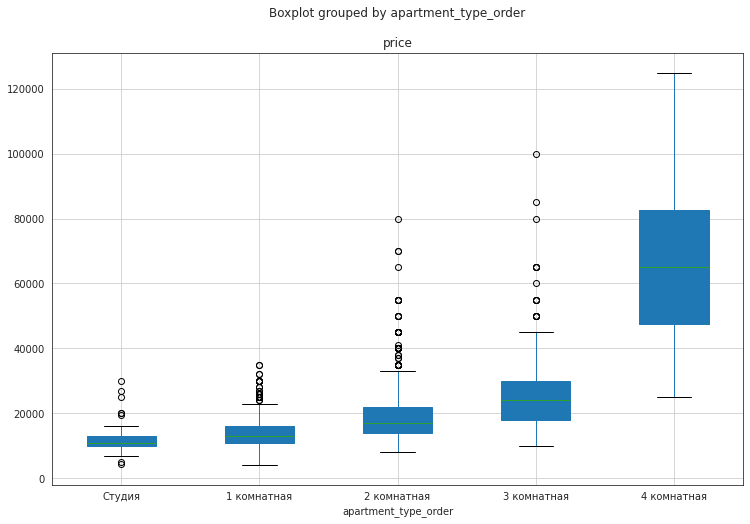

In [106]:
apartment_types = ['Студия', '1 комнатная', '2 комнатная', '3 комнатная', '4 комнатная']
plot_box_chart(flats, 'apartment_type_order',
              [[1, 2, 3, 4, 5], apartment_types])

# Number of apartments by percentage

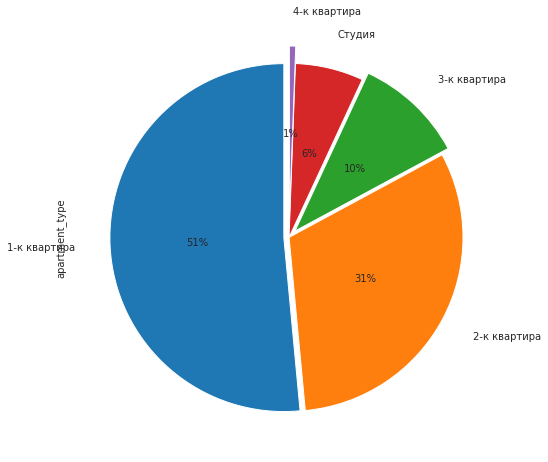

In [94]:
plot_pie_chart(flats, 'apartment_type', explode=[0.03,0.00,0.05, 0.00, 0.1])

# Common price distribution

<Figure size 720x576 with 0 Axes>

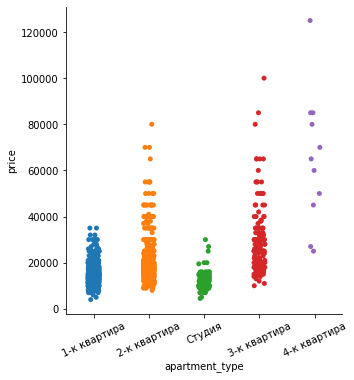

In [29]:
plt.figure(figsize=(10,8))
sns.catplot(x="apartment_type", y="price", data=flats);
plt.xticks(rotation=25) 
plt.ioff()

No handles with labels found to put in legend.


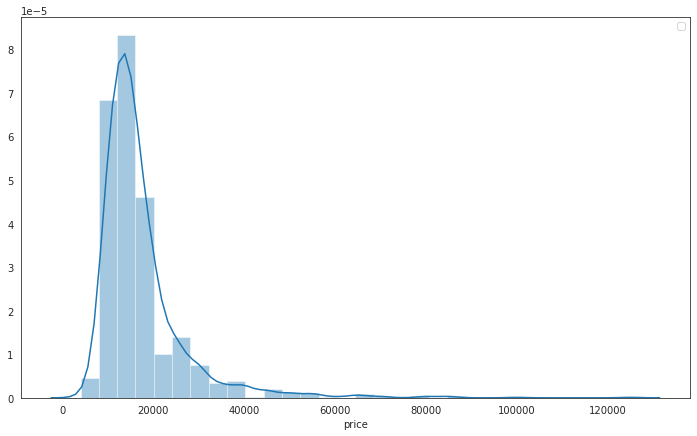

In [109]:
plot_linear_chart(flats, 'price')

No handles with labels found to put in legend.


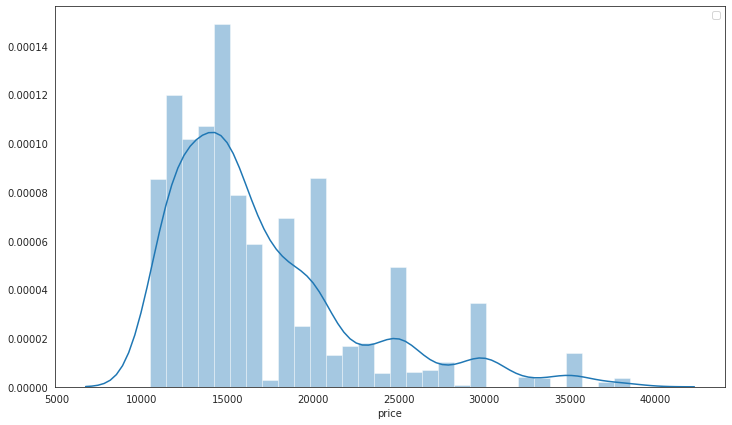

In [110]:
bounded_price_flats = flats[(flats.price > 10_000) & (flats.price < 40_000)]

plot_linear_chart(bounded_price_flats, 'price')

# Basic statistics by `area`

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


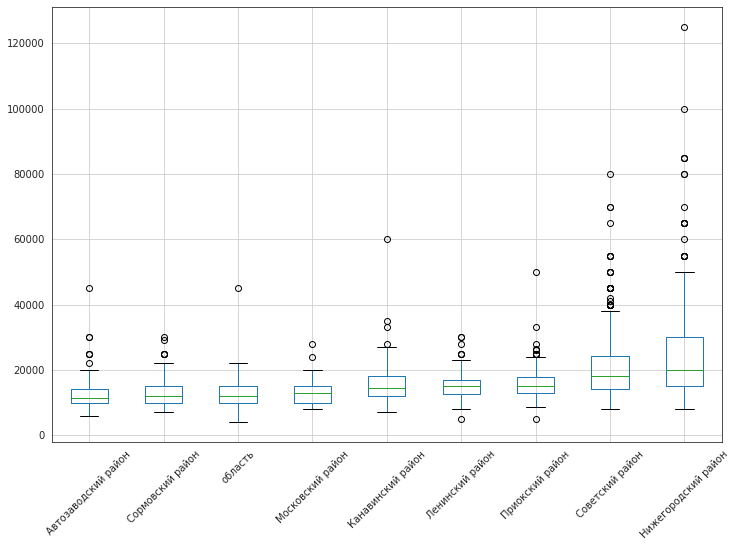

In [111]:
boxplot_sorted(flats, 'area', 'price', 45)

<Figure size 1152x1152 with 0 Axes>

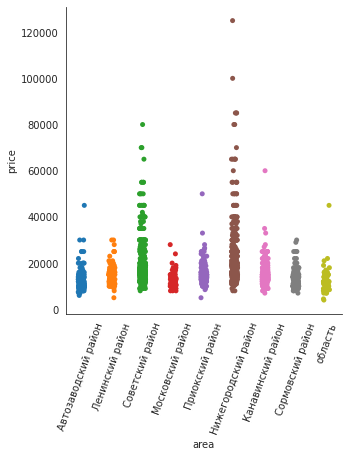

In [112]:
plt.figure(figsize=(16,16))
sns.catplot(x="area", y="price", data=flats);
plt.xticks(rotation=70)
plt.ioff()

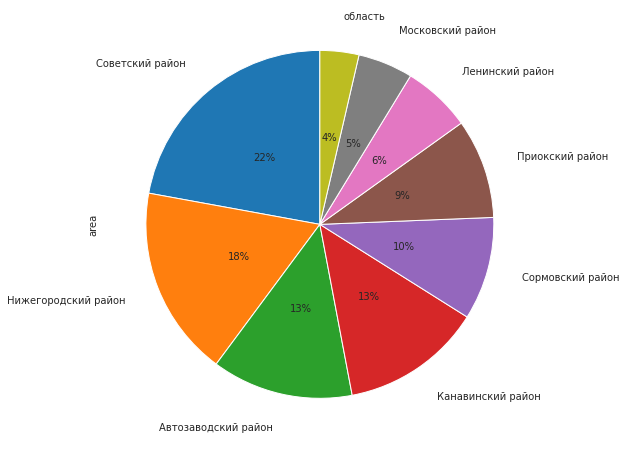

In [113]:
plot_pie_chart(flats, 'area')

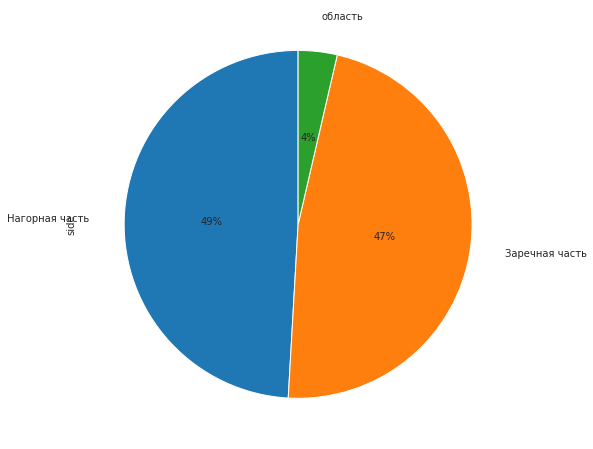

In [114]:
plot_pie_chart(flats, 'side')

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


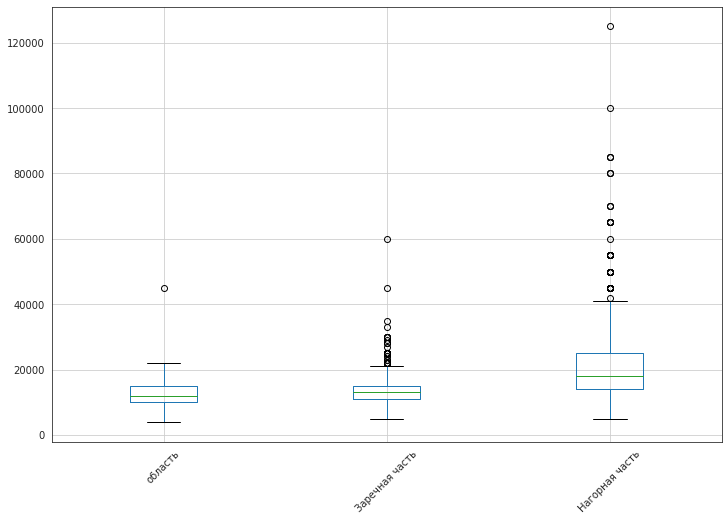

In [115]:
boxplot_sorted(flats, 'side', 'price', 45)

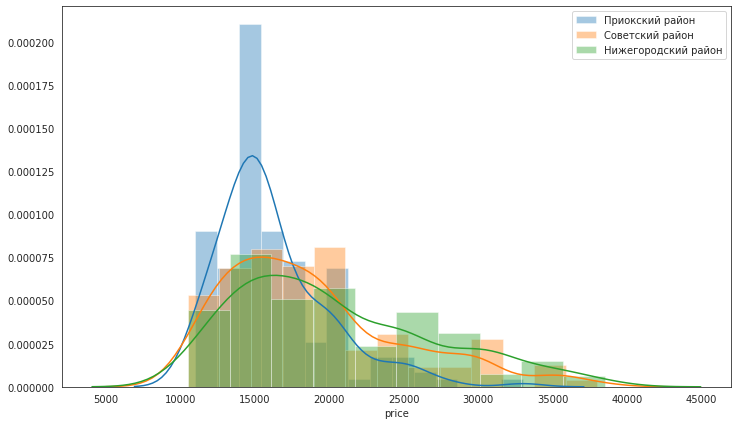

In [116]:
plot_linear_chart(bounded_price_flats, 'area', ['Приокский район', 'Советский район', 'Нижегородский район'])

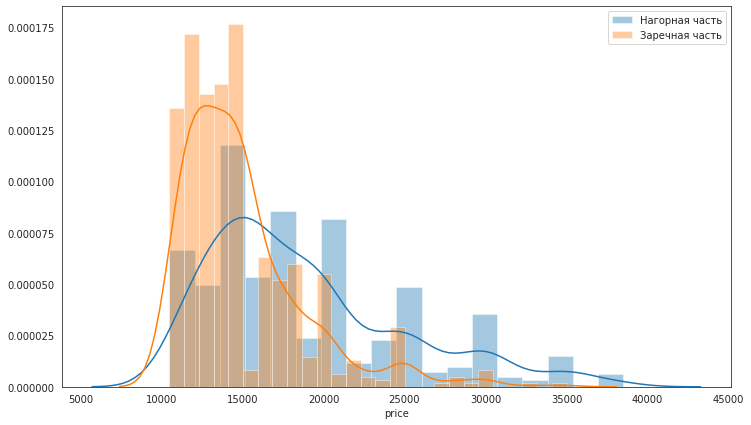

In [117]:
plot_linear_chart(bounded_price_flats, 'side', ['Нагорная часть', 'Заречная часть'])

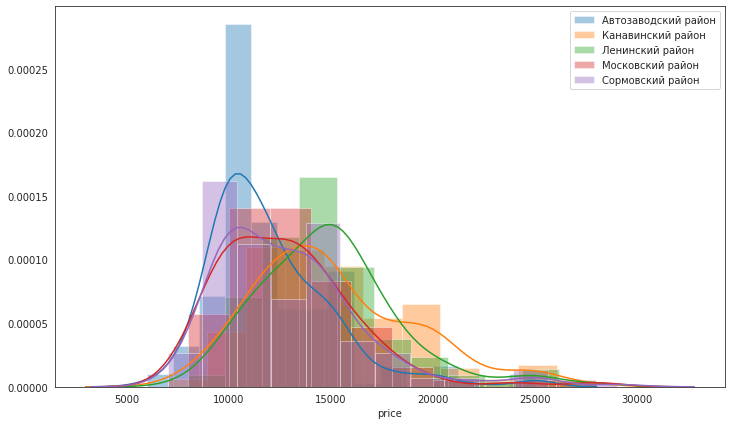

In [118]:
bounded_price_flats = flats[(flats.price > 5_000) & (flats.price < 30_000)]

plot_linear_chart(bounded_price_flats, 'area', 
                  ['Автозаводский район', 'Канавинский район', 'Ленинский район', 'Московский район', 'Сормовский район'])

In [119]:
metro_importance = flats[(flats['metro_station']!='Горьковская') & (flats['metro_station']!='без метро')]

In [120]:
bounded_price_flats = bound_flats_py_price(metro_importance)

In [121]:
bounded_price_flats.metro_station.unique()

array(['Парк Культуры', 'Заречная', 'Ленинская', 'Канавинская',
       'Бурнаковская', 'Буревестник', 'Московская', 'Двигатель Революции',
       'Чкаловская', 'Стрелка', 'Пролетарская', 'Комсомольская',
       'Кировская', 'Автозаводская'], dtype=object)

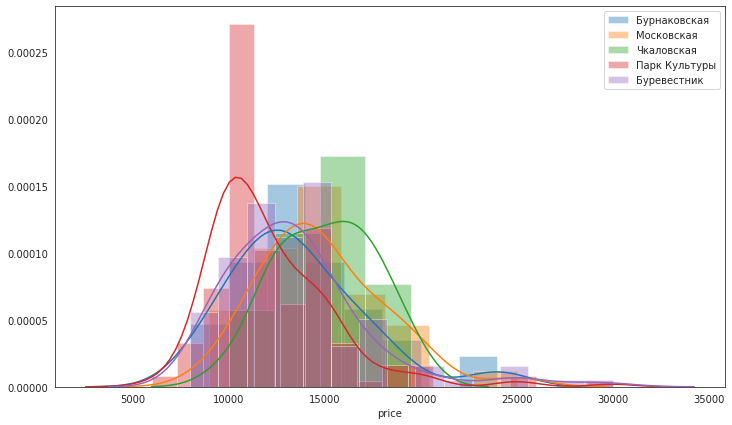

In [122]:
plot_linear_chart(bounded_price_flats, 'metro_station', 
                  ['Бурнаковская', 'Московская', 'Чкаловская', 'Парк Культуры', 'Буревестник'])

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


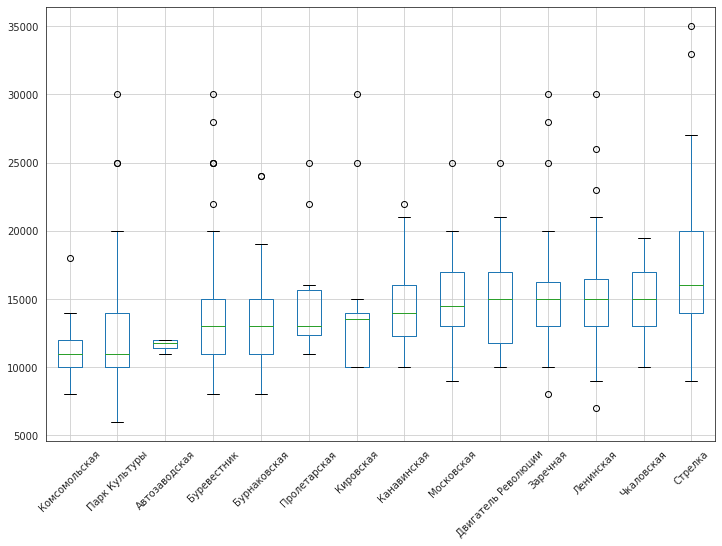

In [123]:
boxplot_sorted(bounded_price_flats, 'metro_station', 'price', 45)

# Basic statistics by `floor`

#### We can see more dominance of buildings with 5 and 9 floor. We can assume that old building and following what  more than half of bulding is old

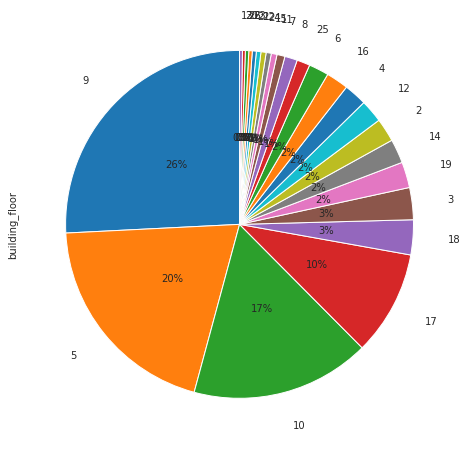

In [128]:
plot_pie_chart(flats, 'building_floor')

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


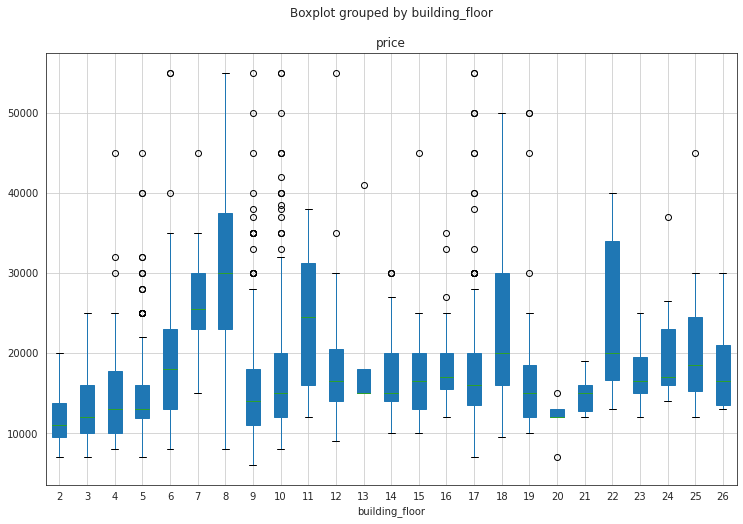

In [135]:
bounded_flats_for_floor_stats = bound_flats_py_price(flats, high=60_000)
plot_box_chart(bounded_flats_for_floor_stats, 'building_floor')

### We was split buildings by 3 floor groups with assamption what price in building with low than 5 floors less then in building with higher than 12 floors

#### And we confirmed it

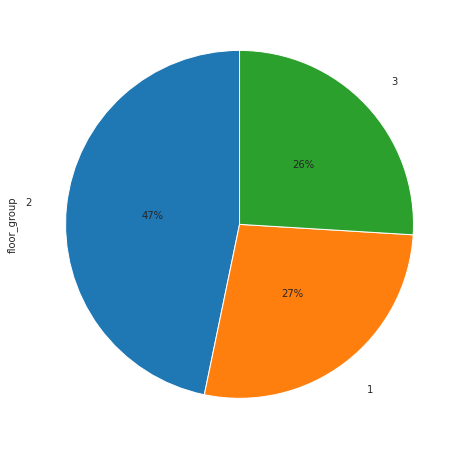

In [139]:
plot_pie_chart(flats, 'floor_group')

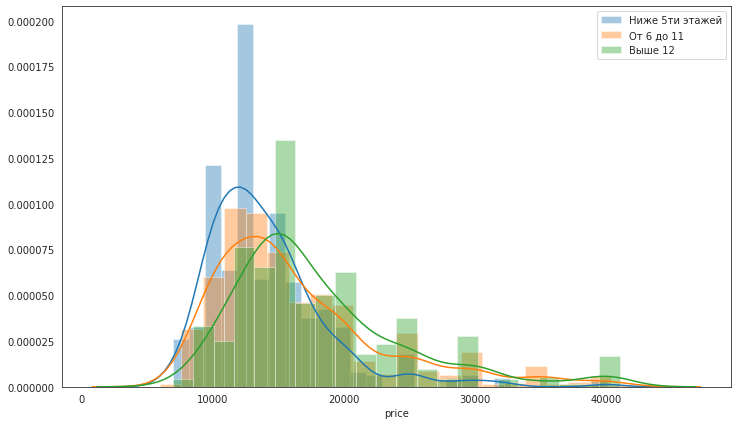

In [133]:
bounded_floor_group = flats[(flats.price > 5_000) & (flats.price < 45_000)]

plot_linear_chart(bounded_floor_group, 'floor_group', [1,2,3], ["Ниже 5ти этажей", "От 6 до 11", "Выше 12"])

## Apartment floor

### We was split buildings by 3 apartment floor groups with assamption what price in apartment on lowest building floor less than in apartment on highest building floor

#### Its quiet similar so we cannot confirm it.

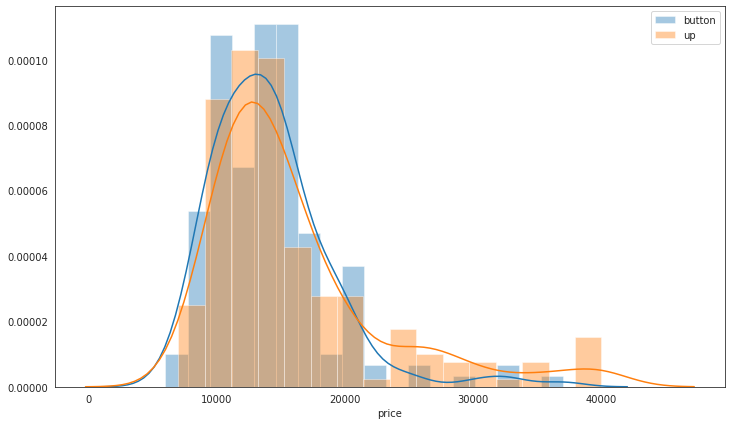

In [136]:
plot_linear_chart(bounded_floor_group, 'apartment_floor_group', ['button', 'up'])

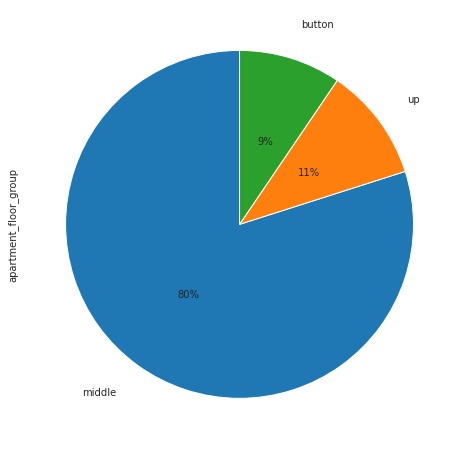

In [137]:
plot_pie_chart(bounded_floor_group, 'apartment_floor_group')

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


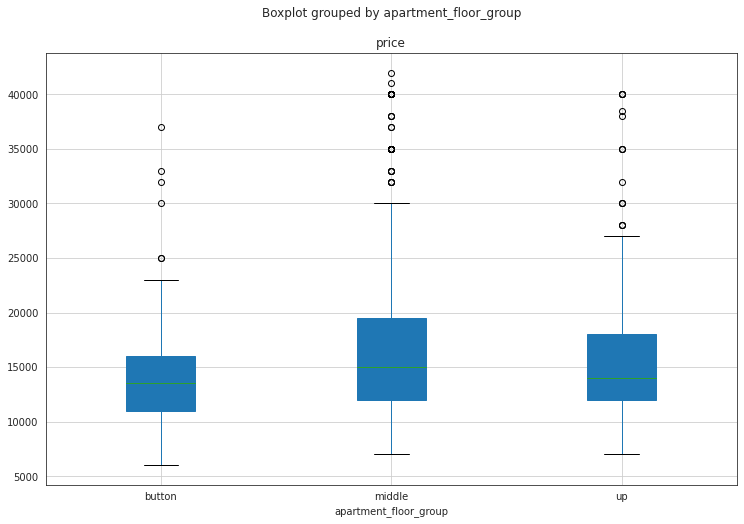

In [138]:
plot_box_chart(bounded_floor_group, 'apartment_floor_group')

## Take a look to metro distance importance 

#### We have a assomption that nearest to metro flats have higher price, but we cannot confirm it becouse we see big value dispersion and for different metro station regression curve has different direction 


In [63]:
flats_with_metro_distance_importance = \
        flats[(flats['metro_station'] != 'Горьковская') 
              & (flats['metro_station'] != 'без метро') 
              & (flats['converted_distance'] is not np.nan)]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

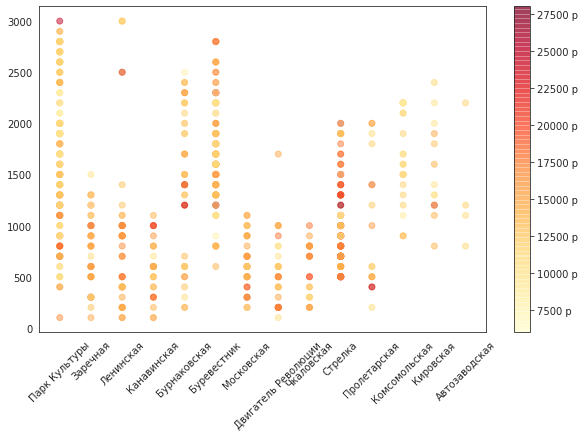

In [145]:
bounded_flats_with_metro_distance_importance = \
        bound_flats_py_price(flats_with_metro_distance_importance, high=30_000)

plt.figure(figsize=(10,6))
sctr = plt.scatter(bounded_flats_with_metro_distance_importance['metro_station'], 
            bounded_flats_with_metro_distance_importance['converted_distance'], 
            c=bounded_flats_with_metro_distance_importance['price'],
            cmap='YlOrRd',
            alpha=0.5)
plt.colorbar(sctr,format='%d р')
plt.xticks(rotation=45)

182


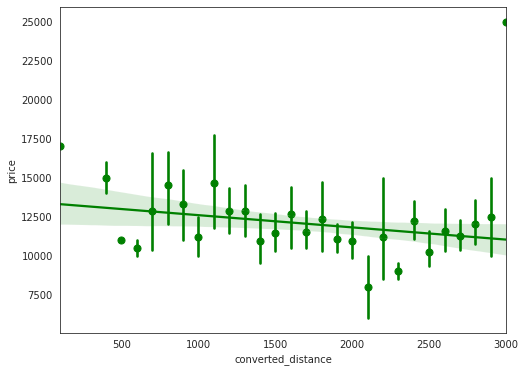

In [148]:
tmp_flats = bounded_flats_with_metro_distance_importance[
    bounded_flats_with_metro_distance_importance['metro_station'] == 'Парк Культуры' 
]

print(len(tmp_flats))
plt.figure(figsize=(8,6))
sns.regplot(tmp_flats['converted_distance'], tmp_flats['price'], color="g", x_estimator=np.mean)

133


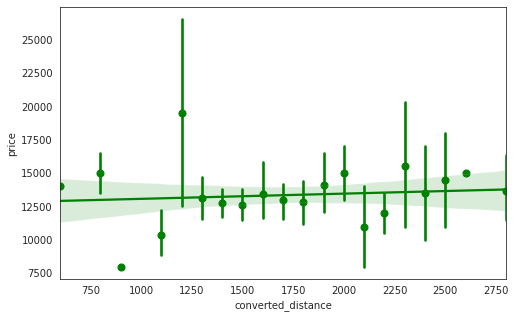

In [150]:
tmp_flats = bounded_flats_with_metro_distance_importance[
    bounded_flats_with_metro_distance_importance['metro_station'] == 'Буревестник' 
]

print(len(tmp_flats))
plt.figure(figsize=(8,5))
sns.regplot(tmp_flats['converted_distance'], tmp_flats['price'], color="g", x_estimator=np.mean)

# Basic statistics by `lat` and `long`

In [68]:
import folium
from folium.plugins import HeatMap
m=folium.Map([56.301365, 43.984700],zoom_start=11)
HeatMap(flats[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

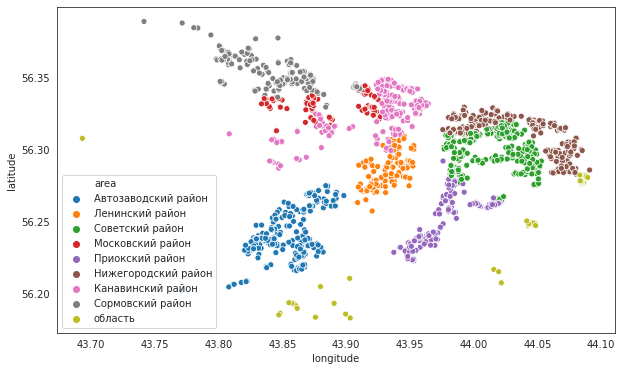

In [69]:
plt.figure(figsize=(10,6))
sns.scatterplot(flats.longitude,flats.latitude,hue=flats.area)
plt.ioff()

(array([43.65, 43.7 , 43.75, 43.8 , 43.85, 43.9 , 43.95, 44.  , 44.05,
        44.1 , 44.15]),
 <a list of 11 Text major ticklabel objects>)

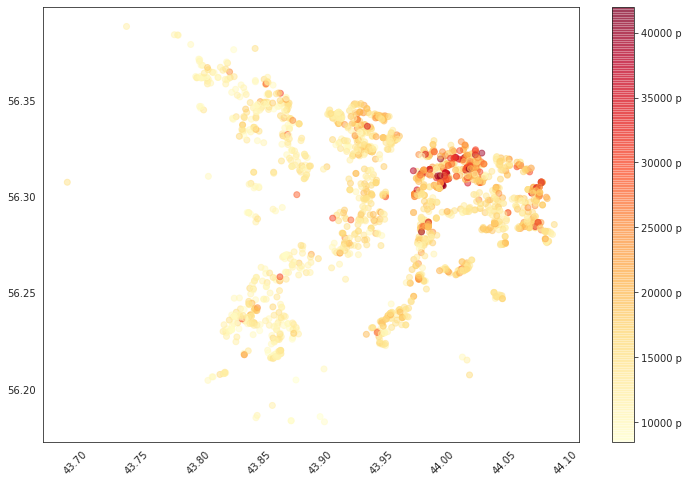

In [142]:
bound_flats_for_lat_and_long = bound_flats_py_price(flats, low=8_000)

plt.figure(figsize=(12,8))  
sctr = plt.scatter(bound_flats_for_lat_and_long['longitude'], 
            bound_flats_for_lat_and_long['latitude'], 
            c=bound_flats_for_lat_and_long['price'],
            cmap='YlOrRd',
            alpha=0.5)
plt.colorbar(sctr,format='%d р')
plt.xticks(rotation=45)

# Compare August 2019 with Jule 2020
---
#### We can observe a general decline in prices. But most of all, prices fell for more expensive and larger apartments. Price spread moved to the mean.

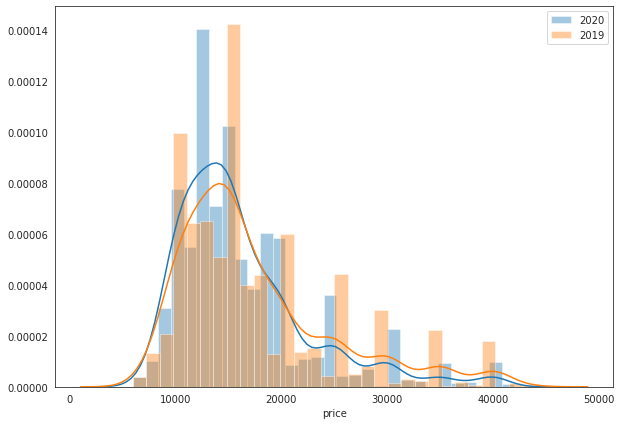

In [178]:
bounded_flats = bound_flats_py_price(flats)
bounded_old_flats = bound_flats_py_price(old_flats)

plt.figure(figsize=(10,7)) 
sns.set_style("white")
sns.distplot(bounded_flats['price'], bins=30, label='2020')
sns.distplot(bounded_old_flats['price'], bins=30, label='2019')
plt.legend()

In [179]:
concat_flats = bounded_flats.append(bounded_old_flats, ignore_index=True, sort=False)

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


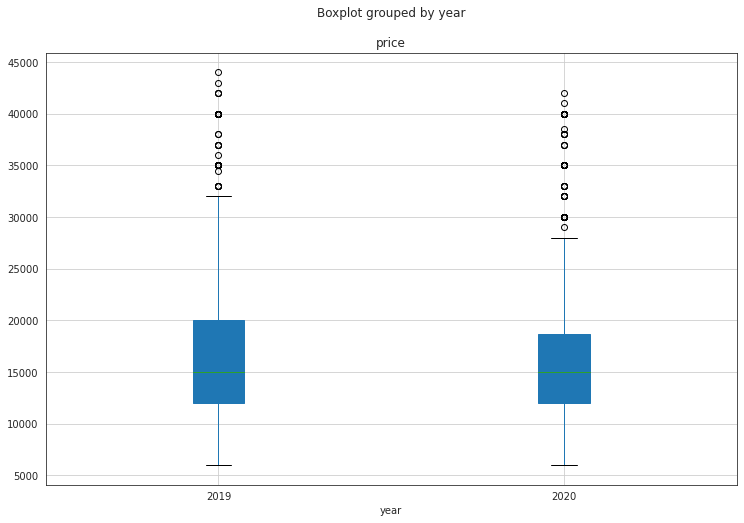

In [180]:
plot_box_chart(concat_flats, 'year')

In [181]:
print('2019: ', bounded_old_flats.mean().price, 'vs 2020: ', bounded_flats.mean().price)

2019:  17522.093385214008 vs 2020:  16238.444871091608


In [182]:
print('2019: ', old_flats.mean().price, 'vs 2020: ', flats.mean().price)

2019:  21371.422776911077 vs 2020:  17410.20478723404


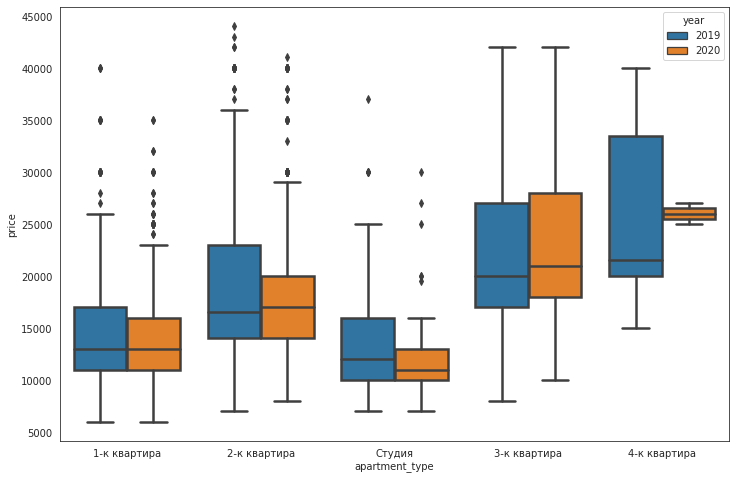

In [183]:
plt.figure(figsize=(12,8)) 
sns.boxplot(x="apartment_type", y="price", hue="year",
                 data=concat_flats, linewidth=2.5)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

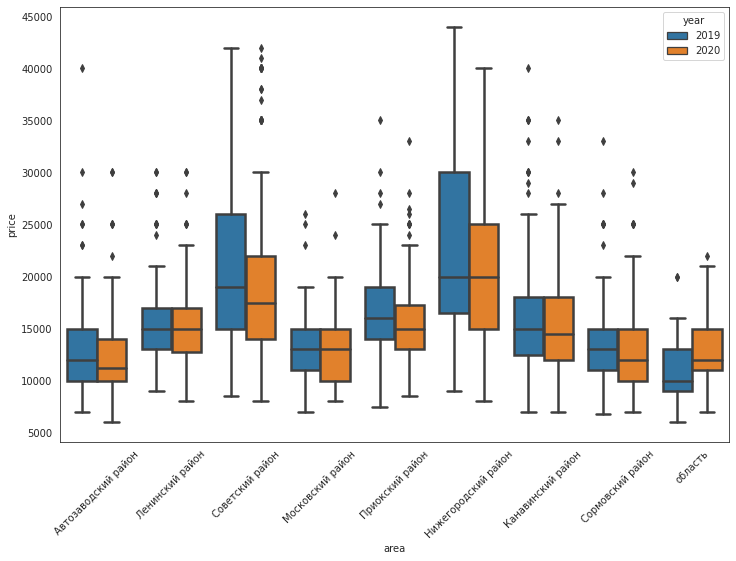

In [184]:
plt.figure(figsize=(12,8)) 
sns.boxplot(x="area", y="price", hue="year",
                 data=concat_flats, linewidth=2.5)
plt.xticks(rotation=45) 